# Dimensionnement de stockage embarqué dans un tramway

## Objectifs du projet :
- Mettre en œuvre une démarche d’optimisation pour la conception d’un système
- Comprendre le principe de l’alimentation électrique des tramways
- Découvrir l’optimisation multi-critères et le concept d’optimalité au sens de Pareto
- Mettre en œuvre l’algorithme génétique NSGA-2

## Presentation du systeme de tramway etudie 

Ce projet porte sur l’étude en simulation d’une ligne de tramway très simple, et plus précisément sur
l’intérêt d’un système de stockage par batterie à bord afin de faire de la récupération d’énergie au
freinage. On souhaite dimensionner et piloter un système de stockage de façon à réduire les chutes de
tension aux bornes du train. Pour cela, il faut réaliser un compromis entre coût et performance du
système de stockage. 

## 1- Mise en place du modèle du système

In [22]:
import scipy.io
import scipy.optimize
import numpy as np 
import matplotlib.pyplot as plt

###  Recuperation des données 


In [23]:
marche = 'marche.txt'
donnee = np.loadtxt(marche)

t= donnee[:, 0] # Temps en seconde 
x = donnee[:, 1] # Position du train en mètrese
dt = t[1] - t[0] # Pas de temps 

### Definition des parametres :


In [24]:
# Données du systeme 
M = 70e3 # Masse du train 
g = 9.81 # Accélération gravitationnelle en m/s^2
A0 , A1 = 780 , 6.4e-3 #Coef de  résistance 
B0, B1 = 0, 0.14e-3*3.6 # Résistance proportionnelle à la vitesse (N/(km/h))
C0, C1 = 0.3634*3.6**2, 0  # Résistance quadratique en fonction de la vitesse (N/(km/h)^2)
alpha = 0  # Pente de la voie (en radians)
eta = 0.8 # Rendement moteur
P_bord = 35e3  # Puissance constante à bord en W


# Données électriques
V_ss1 = 790  # Tension des sous-stations (V)
R_ss1 = 33e-3  # Résistance interne des sous-stations (ohms)
rho_LAC = 131e-6  # Résistance linéique de la LAC (ohms/m)
rho_rail = 18e-6  # Résistance linéique des rails (ohms/m)


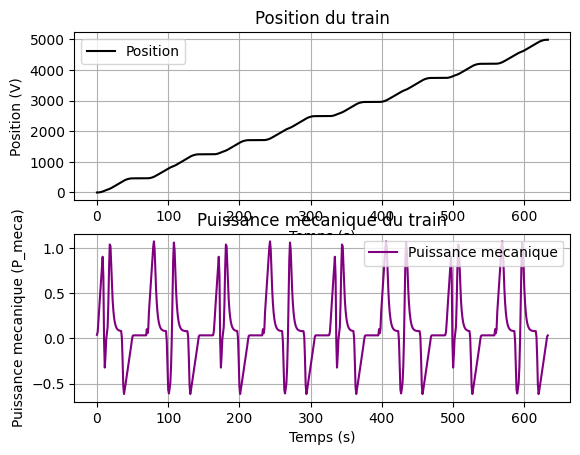

In [25]:

# Calcul de la vitesse (m/s) et de l'accélération (m/s^2)
v = np.gradient(x, dt)  # Vitesse instantanée
a = np.gradient(v, dt)  # Accélération instantanée

# Calcul des forces appliquées
F_gravity = M * g * np.sin(alpha)  # Force gravitationnelle
F_resistance = (A0 + A1 * M) + (B0 + B1 * M) * v + (C0 + C1 * M) * v**2     # Résistance au déplacement
F_moteur = M * a + F_resistance  # Force motrice requise

# Calcul de la puissance mécanique
P_meca = F_moteur * v  # Puissance mécanique en W

# Calcul de la puissance électrique totale
P_train = np.zeros_like(P_meca)  # Initialisation de P_elec

for i in range(len(P_meca)):
   if P_meca[i] >= 0:  # Le moteur consomme de l'énergie
       P_train[i] = (P_meca[i] / eta) + P_bord
   else:  # Le moteur restitue de l'énergie
       P_train[i] = (P_meca[i] * eta) + P_bord
       
plt.subplot(2,1,1)
plt.plot(t,x,label='Position',color='black')
plt.xlabel("Temps (s)")
plt.ylabel("Position (V)")
plt.title("Position du train")
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(t, P_train/1e6,label='Puissance mecanique',color='purple')
plt.xlabel("Temps (s)")
plt.ylabel("Puissance mecanique (P_meca)")
plt.title("Puissance mecanique du train")
plt.legend()
plt.grid()



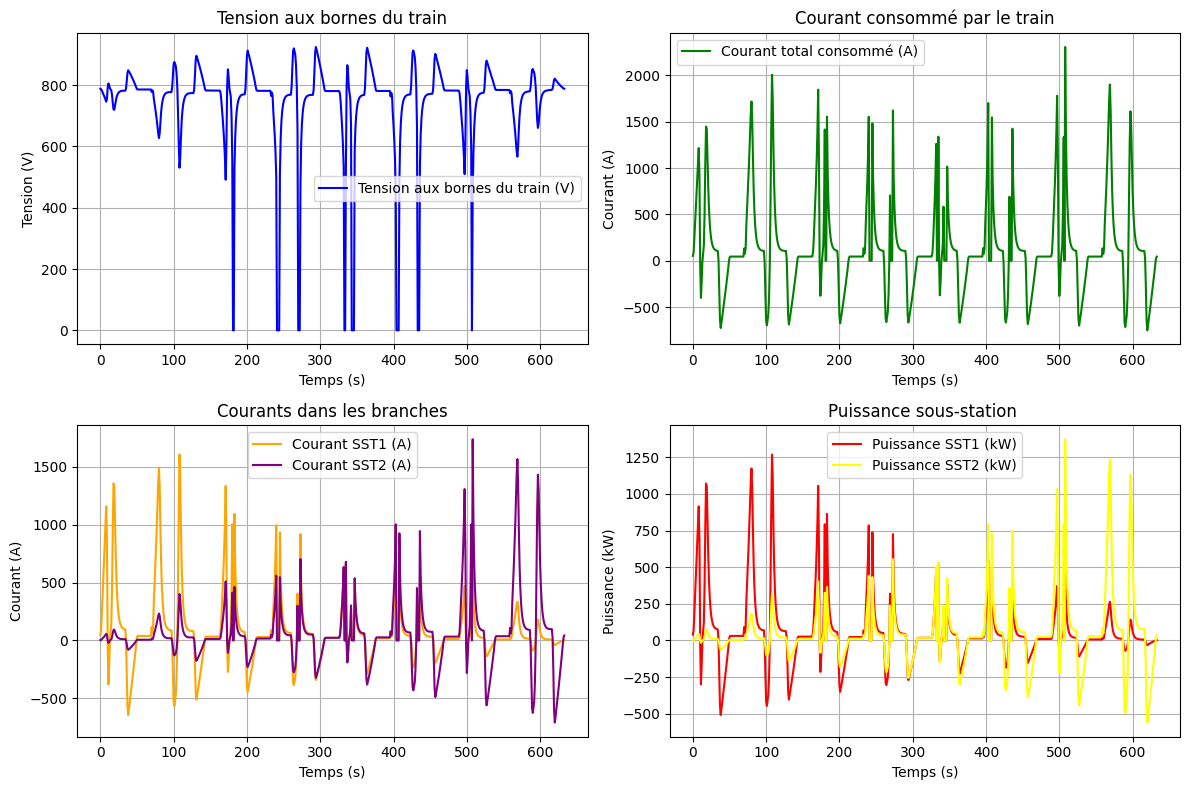

In [26]:
# === Modélisation électrique ===
L_total = x[-1]

# Calcul des résistances des branches
R_LAC1 = rho_LAC * x  # Résistance LAC entre SST1 et train
R_rail1 = rho_rail * x  # Résistance rail entre SST1 et train
R_LAC2 = rho_LAC * (L_total - x)  # Résistance LAC entre SST2 et train
R_rail2 = rho_rail * (L_total - x)  # Résistance rail entre SST2 et train

# Résistance équivalente totale
R_eq = (R_LAC1 + R_rail1 + R_ss1) * (R_LAC2 + R_rail2 + R_ss1) / (
   R_LAC1 + R_rail1 + R_ss1 + R_LAC2 + R_rail2 + R_ss1
)


# Calcul de la tension et des courants
V_train = np.zeros_like(t)
I_train = np.zeros_like(t)
I1 = np.zeros_like(t)
I2 = np.zeros_like(t)

for i in range(len(t)):
   discriminant = V_ss1**2 - 4 * R_eq[i] * P_elec[i]
   if discriminant >= 0:
       V_train[i] = (V_ss1 + np.sqrt(discriminant)) / 2
       I1[i] = (V_ss1-V_train[i]) / (R_LAC1[i] + R_rail1[i] + R_ss1)
       I2[i] = (V_ss1-V_train[i]) / (R_LAC2[i] + R_rail2[i] + R_ss1)
       I_train[i] = (V_ss1-V_train[i])/R_eq[i]
   else:
       V_train[i] = 0
       I1[i] = 0
       I2[i] = 0
       I_train[i] = 0

# Calcul des puissances fournies par les sous-stations
P_ss1 = V_ss1 * I1
P_ss2 = V_ss1 * I2
P_train = P_elec

# === Visualisation des résultats ===
plt.figure(figsize=(12, 8))

# Tension aux bornes du train
plt.subplot(2, 2, 1)
plt.plot(t, V_train, label="Tension aux bornes du train (V)", color="blue")
plt.xlabel("Temps (s)")
plt.ylabel("Tension (V)")
plt.title("Tension aux bornes du train")
plt.legend()
plt.grid()

# Courant total consommé par le train
plt.subplot(2, 2, 2)
plt.plot(t, I_train, label="Courant total consommé (A)", color="green")
plt.xlabel("Temps (s)")
plt.ylabel("Courant (A)")
plt.title("Courant consommé par le train")
plt.legend()
plt.grid()

# Courants dans les branches
plt.subplot(2, 2, 3)
plt.plot(t, I1, label="Courant SST1 (A)", color="orange")
plt.plot(t, I2, label="Courant SST2 (A)", color="purple")
plt.xlabel("Temps (s)")
plt.ylabel("Courant (A)")
plt.title("Courants dans les branches")
plt.legend()
plt.grid()

# Puissance sous-station 1
plt.subplot(2, 2, 4)
plt.plot(t, P_ss1 / 1e3, label="Puissance SST1 (kW)", color="red")
plt.plot(t, P_ss2 / 1e3, label="Puissance SST2 (kW)", color="yellow")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (kW)")
plt.title("Puissance sous-station ")
plt.legend()
plt.grid()



plt.tight_layout()
plt.show()

## 2- Dimensionnement du système de stockage ( Pas fini )

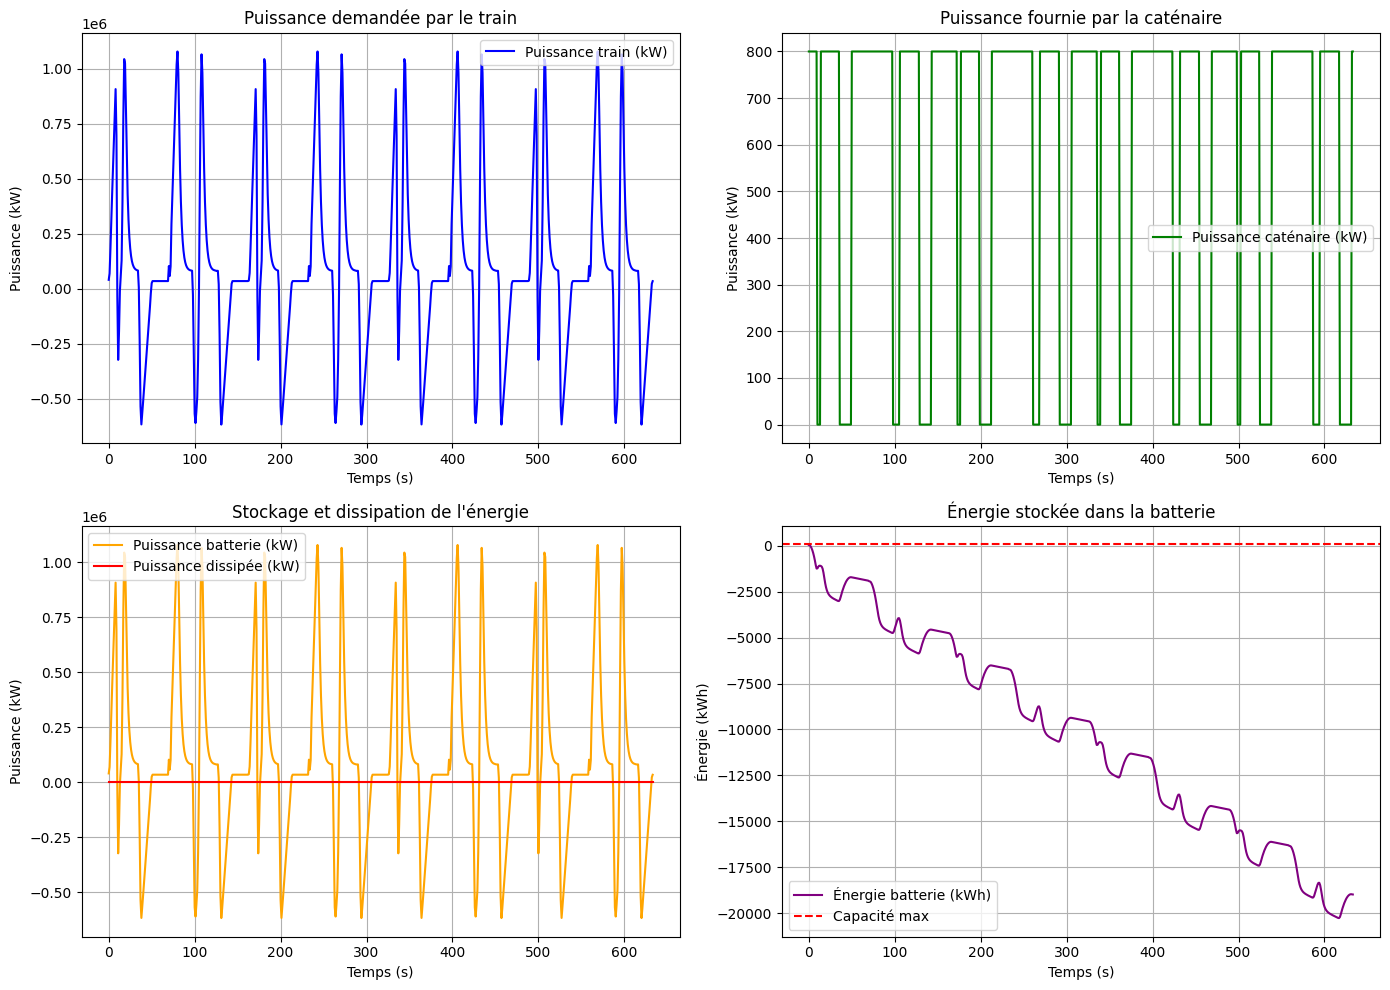

In [21]:
# === Paramètres ===
Energie_batterie_max = 100  # Capacité max de la batterie en kWh
Energie_batterie = 50       # État initial de la batterie en kWh
dt = t[1] - t[0]            # Pas de temps en secondes
P_lac_max = 800             # Puissance maximale de la caténaire en kW

# Initialisation des tableaux
P_lac = np.zeros_like(t)
P_batterie = np.zeros_like(t)
P_reho = np.zeros_like(t)
Energie_batterie_temps = np.zeros_like(t)

# Calcul boucle temporelle
for i in range(len(t)):
    if P_train[i] > 0:  # Phase de traction
        if P_train[i] <= P_lac_max:
            P_lac[i] = P_train[i]
            P_batterie[i] = 0
        else:
            P_lac[i] = P_lac_max
            P_batterie[i] = P_train[i] - P_lac[i]
    else:  # Phase de freinage
        P_batterie_fictif = P_train[i]
        if Energie_batterie >= Energie_batterie_max:
            P_reho[i] = P_batterie_fictif
            P_batterie[i] = 0
        else:
            P_batterie[i] = P_batterie_fictif
            P_reho[i] = 0
    
    # Mise à jour de l'énergie de la batterie
    Energie_batterie += -P_batterie[i] * (dt / 3600)  # Conversion kW -> kWh
    Energie_batterie_temps[i] = Energie_batterie

# === Visualisation ===
plt.figure(figsize=(14, 10))

# Puissance du train
plt.subplot(2, 2, 1)
plt.plot(t, P_train, label="Puissance train (kW)", color="blue")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (kW)")
plt.title("Puissance demandée par le train")
plt.legend()
plt.grid()

# Puissance des caténaires
plt.subplot(2, 2, 2)
plt.plot(t, P_lac, label="Puissance caténaire (kW)", color="green")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (kW)")
plt.title("Puissance fournie par la caténaire")
plt.legend()
plt.grid()

# Puissance batterie et dissipation
plt.subplot(2, 2, 3)
plt.plot(t, P_batterie, label="Puissance batterie (kW)", color="orange")
plt.plot(t, P_reho, label="Puissance dissipée (kW)", color="red")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (kW)")
plt.title("Stockage et dissipation de l'énergie")
plt.legend()
plt.grid()

# Énergie dans la batterie
plt.subplot(2, 2, 4)
plt.plot(t, Energie_batterie_temps, label="Énergie batterie (kWh)", color="purple")
plt.axhline(y=Energie_batterie_max, color="red", linestyle="--", label="Capacité max")
plt.xlabel("Temps (s)")
plt.ylabel("Énergie (kWh)")
plt.title("Énergie stockée dans la batterie")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()